# Breast Cancer Detection 0.1.0 - Base Model 

The aim of this section is to establish a baseline model on unprocessed images as a benchmark for subsequent preprocessing and model enhancements. 

## Setup

Import TensorFlow and other necessary libraries:

In [1]:
import sys
from glob import glob
from datetime import datetime


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import layers 
import tensorflow as tf
from keras import Model
import wandb


from bcd.model.base_model import BaseModel
from bcd.model.callback import DurationCallback
from bcd.model.base import BCDModel
from bcd.model.visual import ModelVisualizer


Load and configure TensorBoard.

In [2]:
%load_ext tensorboard
log_dir = "model/logs/base_model/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Initialize Weights & Bias

In [3]:
wandb.tensorboard.patch(root_logdir=log_dir, save=True, tensorboard_x=True)
wandb.init(project='breast_cancer_detection')

Define the constants used by the data loader and our model.

In [4]:
EPOCHS = 10
BATCH_SIZE = 16
IMG_HEIGHT = 256
IMG_WIDTH = 256


## Load the Data
In total, there are 3565 images in the training and test sets for benign and malignant cases. The breakdown is as follows:

In [5]:

data_dir = "data/image/1_dev/"
data_dir_train = "data/image/1_dev/train/"
data_dir_train_benign = "data/image/1_dev/train/benign/"
data_dir_train_malignant = "data/image/1_dev/train/malignant/"
data_dir_test = "data/image/1_dev/test/"
data_dir_test_benign = "data/image/1_dev/test/benign/"
data_dir_test_malignant = "data/image/1_dev/test/malignant/"

In [6]:
pattern_total = data_dir + "/**/*.png"
pattern_train = data_dir_train + "/**/*.png"
pattern_train_benign = data_dir_train_benign + "/**/*.png"
pattern_train_malignant = data_dir_train_malignant + "/**/*.png"
pattern_test = data_dir_test + "/**/*.png"
pattern_test_benign = data_dir_test_benign + "/**/*.png"
pattern_test_malignant = data_dir_test_malignant + "/**/*.png"
image_count = len(glob(pattern_total, recursive=True))
image_count_train = len(glob(pattern_train, recursive=True))
image_count_train_benign = len(glob(pattern_train_benign, recursive=True))
image_count_train_malignant = len(glob(pattern_train_malignant, recursive=True))
image_count_test = len(glob(pattern_test, recursive=True))
image_count_test_benign = len(glob(pattern_test_benign, recursive=True))
image_count_test_malignant = len(glob(pattern_test_malignant, recursive=True))

d = {'Benign': [image_count_train_benign, image_count_test_benign], 'Malignant': [image_count_train_malignant, image_count_test_malignant], "Total": [image_count_train, image_count_test]}
df =pd.DataFrame(data=d, index=['Train', 'Test'])
df

,Benign,Malignant,Total
Train,1680,1181,2861
Test,428,276,704


### Create a dataset
Our images are organized into folders by dataset and class label as follows:

```
train/
    benign/
    malignant/
test/
    benign/
    malignant/
```
Calling the image_dataset_from_directory method will return a tf.data.Dataset that yields batches of images from the benign and malignant directories, along with their class labels. We've set the batch size to 16, and will reserve 20% of the training set for validation. 

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  batch_size=BATCH_SIZE)

Found 2861 files belonging to 2 classes.
Using 2289 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  batch_size=BATCH_SIZE)

Found 2861 files belonging to 2 classes.
Using 572 files for validation.


Class name, number of classes, and batch input shape are required for the model below.

In [9]:
class_names = train_ds.class_names
num_classes = len(class_names)
for image_batch, labels_batch in train_ds:
  input_shape = image_batch.shape
  break

Here, we use buffered prefetching, so that we can yield data from disk without having I/O become blocking.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Visualize the Data

Here are the first nine images from the training dataset:

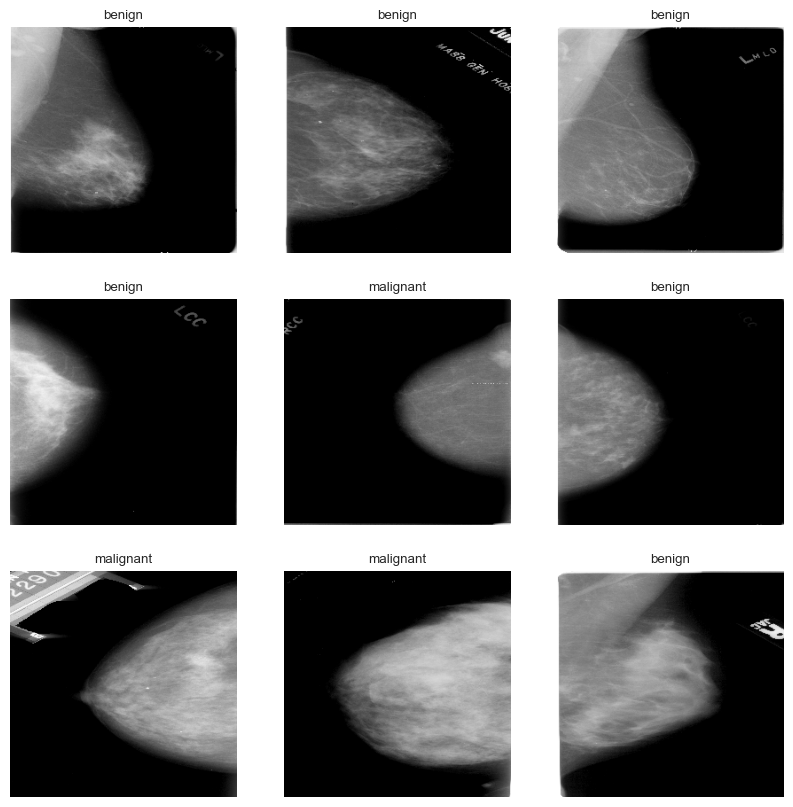

In [11]:
import matplotlib.pyplot as plt

_ = plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    _ = plt.imshow(images[i].numpy().astype("uint8"))
    _ = plt.title(class_names[labels[i]])
    _ = plt.axis("off")

Artifacts, such as those shown above, often reduce model accuracy as neural networks learn to distinguish regions of interest and to accurately classify abnormalities. In our next iteration, we'll implement denoising and artifact removal methods to address those anomalies.

## Build Base Model

### Create the model
The base model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. To reduce potential overfitting, a dropout layer has been added. On top of that, we have a fully connected layer (`tf.keras.layers.Dense`) with 128 units which are activated by a ReLU activation function (`'relu'`). Finally, an output layer will render the class probabilities that will be used to determine the class labels. This model has not been tuned for high accuracy as the goal of this exercise is to get a computationally efficient baseline model *fast*.

In [12]:
# %load -r 20-69 bcd/model/base_model.py
class BaseModel(BCDModel):
    """Base Model"""

    def __init__(self, img_height: int, img_width: int, num_classes: int):
        super().__init__()
        self._img_height = img_height
        self._img_width = img_width
        self._num_classes = num_classes
        self.resizing = layers.Resizing(height=img_height, width=img_width)
        self.rescaling = layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3))
        self.conv1 = layers.Conv2D(16, 3, padding="same", activation="relu")
        self.maxpooling1 = layers.MaxPooling2D()
        self.conv2 = layers.Conv2D(32, 3, padding="same", activation="relu")
        self.maxpooling2 = layers.MaxPooling2D()
        self.conv3 = layers.Conv2D(64, 3, padding="same", activation="relu")
        self.maxpooling3 = layers.MaxPooling2D()
        self.dropout = layers.Dropout(0.2)
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(128, activation="relu")
        self.classification = layers.Dense(num_classes)

    def call(self, x):
        x = self.resizing(x)
        x = self.rescaling(x)
        x = self.conv1(x)
        x = self.maxpooling1(x)
        x = self.conv2(x)
        x = self.maxpooling2(x)
        x = self.conv3(x)
        x = self.maxpooling3(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dense(x)
        return self.classification(x)

    def get_config(self) -> dict:
        return {
            "img_height": self._img_height,
            "img_width": self._img_width,
            "num_classes": self._num_classes,
        }


In [13]:

model = BaseModel(img_height=IMG_HEIGHT, img_width=IMG_WIDTH, num_classes=num_classes)

### Compile the model

For this model, we will use the 'adam' optimizer. Our loss function will be categorical cross-entropy and we'll evaluate the model's accuracy.

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.build(input_shape=input_shape)

### Model summary
The model summary provides a view all the layers and their parameter counts.

In [16]:
model.summary()

Model: "basemodel_2023-11-05_18-47-45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         multiple                  0         
                                                                 
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  448       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  4640      
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                 

### Train the model
As indicated above, we'll train the model for 10 epochs.

In [17]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[tensorboard_callback]
)

Epoch 1/10
144/144 [==============================] - 114s 768ms/step - loss: 0.6649 - accuracy: 0.6033 - val_loss: 0.6343 - val_accuracy: 0.6294
Epoch 2/10
144/144 [==============================] - 73s 508ms/step - loss: 0.5660 - accuracy: 0.6833 - val_loss: 0.6121 - val_accuracy: 0.6591
Epoch 3/10
144/144 [==============================] - 75s 520ms/step - loss: 0.4756 - accuracy: 0.7575 - val_loss: 0.6669 - val_accuracy: 0.6748
Epoch 4/10
144/144 [==============================] - 75s 518ms/step - loss: 0.3868 - accuracy: 0.8078 - val_loss: 0.7618 - val_accuracy: 0.6696
Epoch 5/10
144/144 [==============================] - 74s 516ms/step - loss: 0.2860 - accuracy: 0.8755 - val_loss: 0.8846 - val_accuracy: 0.6888
Epoch 6/10
144/144 [==============================] - 80s 553ms/step - loss: 0.2071 - accuracy: 0.9187 - val_loss: 1.0065 - val_accuracy: 0.6818
Epoch 7/10
144/144 [==============================] - 76s 527ms/step - loss: 0.1796 - accuracy: 0.9384 - val_loss: 1.1385 - val_a

## Visualize training results

Here, we examine the loss and accuracy for the training and validation sets.

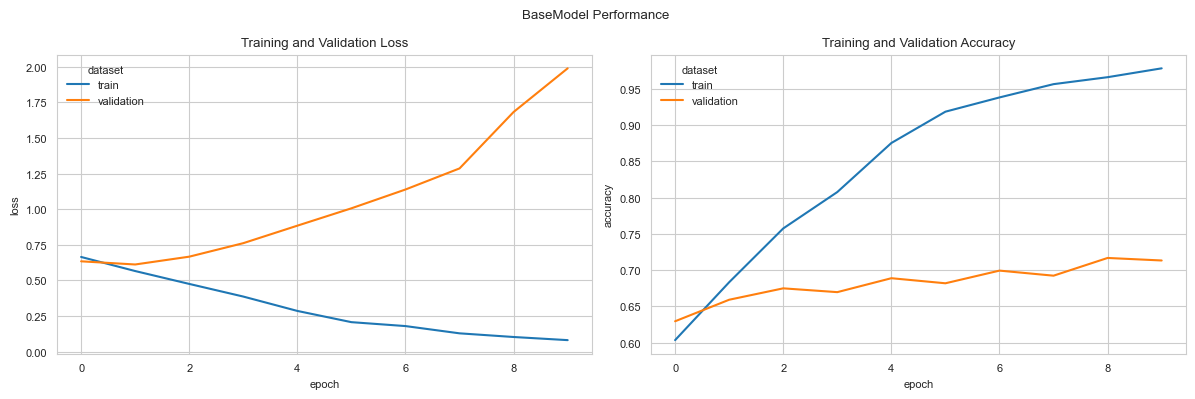

In [18]:
vis = ModelVisualizer(model_name='BaseModel', history=history)
vis.visualize_training()

With no image preprocessing, our base model achieved accuracy of 98% on the training set; yet, the plots reveal a significant departure between training and validation accuracy. The training accuracy increases linearly over time; whereas validation accuracy flattens at 71% - sign of overfitting. 

Several factors may contribute to the models inability to generalize beyond the training examples. Our training set contains approximately 2860 images, a relatively small number of training samples in the modern context, Neural networks that operate on small sample sets learn not only from the signal, but the noise in the images. Artifacts, as those shown above, complicate the learning process, especially for smaller training sets. That said, its worth emphasizing that our base model was not selected or tuned for this problem set. 

## Next Steps
In the next section, we'll evaluate the degree to which image preprocessing affects model performance. Once the data have been appropriately pre-conditioned, we'll explore the impact of various model architectures on classification performance.

In [20]:
wandb.finish()